**Derived Datasets**

This notebook is a starting point for Assignment 4. In this assignment, you will perform a classification empirical study. This notebook will help you to create derived datasets in Section 2 of the assignment.

In [ ]:
#let's start by installing spaCy
!pip install spacy

In [ ]:
import spacy
import pandas as pd
import numpy as np

You have been given a list of datasets in the assignment description. Choose one of the datasets and provide the link below and read the dataset using pandas. You should provide a link to your own Github repository even if you are using a reduced version of a dataset from your TA's repository.

add description of the dataset and your justification of the choices made to obtain the derived datasets

In [ ]:
#Load the dataset you chose.
# Make sure the Notebook can load your dataset, just like previous assignments.

url = 'https://raw.githubusercontent.com/Geshanth/AirPassengerReviews/main/reduced_file_AirPassengerReviews.csv'

#provide the link to the raw version of dataset. You *need* to provide a link to *your own* github repository. DO NOT use the link that is provided as an example.

In [ ]:
print(url)
data = pd.read_csv(url, nrows=100)

https://raw.githubusercontent.com/Geshanth/AirPassengerReviews/main/reduced_file_AirPassengerReviews.csv


In [ ]:
data.head()

,customer_review,NPS Score
0,London to Izmir via Istanbul. First time I'd ...,Passive
1,Istanbul to Bucharest. We make our check in i...,Detractor
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor


This is where you create the NLP pipeline. load() will download the correct model (English).

In [ ]:
nlp = spacy.load("en_core_web_sm")

Applying the pipeline to every sentences creates a Document where every word is a Token object.

Doc: https://spacy.io/api/doc

Token: https://spacy.io/api/token

In [ ]:
#Apply nlp pipeline to the column that has your sentences.
data['tokenized'] = data['customer_review'].apply(nlp)

In [ ]:
data.head()

,customer_review,NPS Score,tokenized
0,London to Izmir via Istanbul. First time I'd ...,Passive,"( , London, to, Izmir, via, Istanbul, ., First..."
1,Istanbul to Bucharest. We make our check in i...,Detractor,"( , Istanbul, to, Bucharest, ., We, make, our,..."
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor,"( , Rome, to, Prishtina, via, Istanbul, ., I, ..."
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter,"( , Flew, on, Turkish, Airlines, IAD, -, IST, ..."
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor,"( , Mumbai, to, Dublin, via, Istanbul, ., Neve..."


A Token object has many attributes such as part-of-speech (pos_), lemma (lemma_), etc. Take a look at the documentation to see all attributes.

The following function is an example on how you can fetch a specific pos tagging from a sentence. We return the lemmatization because we only want the infinitive word.

- In this step, we create a derived dataset, derived_dataset1, focusing on the extraction of verbs from each customer review. The choice of verbs is motivated by the potential significance of identifying action-oriented language and sentiments expressed in the reviews.
- We also constructed derived_dataset2, incorporating information about nouns, proper nouns, and named entities from each customer review. The inclusion of named entities aims to capture specific entities like dates, organizations, and people, potentially offering richer context and meaning to the dataset.


In [ ]:
#create empty dataframes that will store your derived datasets

derived_dataset1 = pd.DataFrame(columns = ['Class', 'pos'])
derived_dataset2 = pd.DataFrame(columns = ['Class', 'pos-np'])

In [ ]:
def get_pos(sentence, wanted_pos): #wanted_pos refers to the desired pos tagging
    verbs = []
    for token in sentence:
        if token.pos_ in wanted_pos:
            verbs.append(token.lemma_) # lemma returns a number. lemma_ return a string
    return ' '.join(verbs) # return value is as a string and not a list for countVectorizer

In [ ]:
#As an example, we use the above function to fetch all the verbs. We store this information in our first derived dataset
derived_dataset1['pos'] = data['tokenized'].apply(lambda sent : get_pos(sent, ['VERB']))

In [ ]:
derived_dataset1.head()

,Class,pos
0,NaN,fly find delay miss speak give speak get make ...
1,NaN,make take go let ™ say overbooke have wait bring
2,NaN,fly say get fly have try ask connect relax lan...
3,NaN,return maintain fly leave use seem have show h...
4,NaN,travel get have ask stay care make keep wait


In [ ]:
derived_dataset2['pos-np'] = data['tokenized'].apply(lambda sent: get_pos(sent, ['NOUN', 'PROPN']))

In [ ]:
#For Derived Dataset 2, you also need to include Named Entities
#Below is just an example of obtaining such entities on a specific sentence, but you would do NER
#on the dataset of your choice.
#You can choose the types of entities (dates, organization, people) that you want,
#and then in your derived dataset, just make sure you include these entities separated by spaces (as shown for verbs)
#in a previous cell.

sentence = "apple is looking at buying U.K. startup for $1 billion"
doc = nlp(sentence)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

# Include Named Entities (NE) in Derived Dataset 2
def get_named_entities(sentence):
    entities = []
    for ent in sentence.ents:
        entities.append(ent.text)
    return ' '.join(entities)


apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [ ]:
# Apply the function to get named entities for each sentence
derived_dataset2['named_entities'] = data['tokenized'].apply(get_named_entities)

# Combine pos-np and named_entities columns into a single column for Derived Dataset 2
derived_dataset2['pos-np'] = derived_dataset2['pos-np'] + ' ' + derived_dataset2['named_entities']

In [ ]:
# Display Derived Dataset 2
derived_dataset2.head()

,Class,pos-np,named_entities
0,NaN,London Izmir Istanbul time TK air cabin crew p...,London Izmir Istanbul First LHR Istanbul Engli...
1,NaN,Istanbul Bucharest check airport luggage gate ...,Istanbul two two 5 the morning 2 hours first
2,NaN,Rome Prishtina Istanbul company time year Rome...,Rome Prishtina Istanbul the past years Rome Pr...
3,NaN,Flew Turkish Airlines IAD IST KHI KHI IST IAD ...,Turkish Airlines Turkish Airlines first 2007 A...
4,NaN,Mumbai Dublin Istanbul book airline Dublin Mum...,Mumbai Dublin Istanbul Turkish Dublin Mumbai M...


Now that you have your derived datasets, you can move to perform your classificaton task.

##**Perform Classification Task**

####1. Encode the text as input features with associated values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

To facilitate the modeling process, we apply preprocessing to the text data. This involves lemmatization (reducing words to their base form), and removing stop words and punctuation. The resulting preprocessed_text column contains cleaned and standardized text data.

In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Add any additional preprocessing steps here, such as removing stop words and punctuation
    # You can use spaCy's default stop words for this
    return ' '.join([token.lemma_ for token in text if not token.is_stop and not token.is_punct])

# Apply the preprocessing function to your tokenized columns
data['preprocessed_text'] = data['tokenized'].apply(preprocess_text)
derived_dataset1['preprocessed_text'] = derived_dataset1['pos'].apply(lambda x: ' '.join(x.split()))
derived_dataset2['preprocessed_text'] = derived_dataset2['pos-np'].apply(lambda x: ' '.join(x.split()))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'], data['NPS Score'], test_size=0.2, random_state=42)

# Use CountVectorizer to convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


#######THIS IS A SAMPLE MODEL NB

# # Train a simple model (Naive Bayes for example)
# classifier = MultinomialNB()
# classifier.fit(X_train_vectorized, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test_vectorized)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print("Classification Report:\n", report)


###2. Define 2 models using some default parameters

a) **Logistic Regression Model:**

A Logistic Regression model with default parameters is chosen for its simplicity and effectiveness in text classification tasks. The model is trained, tested, and evaluated using cross-validation. Performance metrics such as precision and recall are computed for both micro and macro averages.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Assuming you have your data and target variable (X_train, X_test, y_train, y_test) already defined

# Create a pipeline with CountVectorizer and Logistic Regression
model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'], data['NPS Score'], test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

   Detractor       0.93      1.00      0.97        14
     Passive       0.00      0.00      0.00         2
    Promoter       0.67      0.50      0.57         4

    accuracy                           0.80        20
   macro avg       0.53      0.50      0.51        20
weighted avg       0.79      0.80      0.79        20



b) **Multilayer Perception Model:**

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_default = MLPClassifier()  # Default hidden layer size (100)

# Define pipeline with CountVectorizer
pipeline_default = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', mlp_default)
])

pipeline_default.fit(X_train, y_train)

# Make predictions on the test set
y_pred1 = pipeline_default.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred1)
report1 = classification_report(y_test, y_pred1)

print(f"Accuracy: {accuracy1}")
print("Classification Report:\n", report1)


Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

   Detractor       0.88      1.00      0.93        14
     Passive       0.00      0.00      0.00         2
    Promoter       1.00      0.75      0.86         4

    accuracy                           0.85        20
   macro avg       0.62      0.58      0.60        20
weighted avg       0.81      0.85      0.82        20



###**3. Train/test/evaluate your 2 models**

a) **Logistic Regression Model:**

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
data['preprocessed_text'] = data['tokenized'].apply(preprocess_text)

# Combine 'preprocessed_text' with 'NPS Score' for Derived Dataset 1
derived_dataset1 = pd.DataFrame({
    'preprocessed_text': data['preprocessed_text'],
    'Class': data['NPS Score']
})

# Combine 'preprocessed_text' with 'NPS Score' and 'pos-np' for Derived Dataset 2
derived_dataset2 = pd.DataFrame({
    'preprocessed_text': data['preprocessed_text'],
    'Class': data['NPS Score']
})

# Drop rows with NaN values in the relevant columns
derived_dataset1 = derived_dataset1.dropna(subset=['preprocessed_text', 'Class'])
derived_dataset2 = derived_dataset2.dropna(subset=['preprocessed_text',  'Class'])

# Define datasets after handling NaN values
X_derived1 = derived_dataset1['preprocessed_text']
y_derived1 = derived_dataset1['Class']

X_derived2 = derived_dataset2['preprocessed_text']
y_derived2 = derived_dataset2['Class']

# Define Logistic Regression model with default parameters
logistic_regression_model = LogisticRegression()

# Define pipeline with CountVectorizer
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', logistic_regression_model)
])

pipeline_derived2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', logistic_regression_model)
])

# Function to train, test, and evaluate the model
def train_test_evaluate(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=4)

    # Calculate precision and recall for micro and macro averages
    precision_micro = precision_score(y, y_pred, average='micro')
    recall_micro = recall_score(y, y_pred, average='micro')
    precision_macro = precision_score(y, y_pred, average='macro')
    recall_macro = recall_score(y, y_pred, average='macro')

    return precision_micro, recall_micro, precision_macro, recall_macro

# Train, test, and evaluate the models
precision_micro_original, recall_micro_original, precision_macro_original, recall_macro_original = train_test_evaluate(pipeline, data['customer_review'], data['NPS Score'])
precision_micro_derived1, recall_micro_derived1, precision_macro_derived1, recall_macro_derived1 = train_test_evaluate(pipeline, X_derived1, y_derived1)
precision_micro_derived2, recall_micro_derived2, precision_macro_derived2, recall_macro_derived2 = train_test_evaluate(pipeline_derived2, X_derived2, y_derived2)

# Print the results for Derived Dataset 2

# Print the results
print("Original Dataset - Precision (Micro):", precision_micro_original)
print("Original Dataset - Recall (Micro):", recall_micro_original)
print("Original Dataset - Precision (Macro):", precision_macro_original)
print("Original Dataset - Recall (Macro):", recall_macro_original)

print("Derived Dataset 1 - Precision (Micro):", precision_micro_derived1)
print("Derived Dataset 1 - Recall (Micro):", recall_micro_derived1)
print("Derived Dataset 1 - Precision (Macro):", precision_macro_derived1)
print("Derived Dataset 1 - Recall (Macro):", recall_macro_derived1)

print("Derived Dataset 2 - Precision (Micro):", precision_micro_derived2)
print("Derived Dataset 2 - Recall (Micro):", recall_micro_derived2)
print("Derived Dataset 2 - Precision (Macro):", precision_macro_derived2)
print("Derived Dataset 2 - Recall (Macro):", recall_macro_derived2)



Original Dataset - Precision (Micro): 0.8
Original Dataset - Recall (Micro): 0.8
Original Dataset - Precision (Macro): 0.6798433048433049
Original Dataset - Recall (Macro): 0.6256448412698412
Derived Dataset 1 - Precision (Micro): 0.8
Derived Dataset 1 - Recall (Micro): 0.8
Derived Dataset 1 - Precision (Macro): 0.6883568075117371
Derived Dataset 1 - Recall (Macro): 0.6426587301587302
Derived Dataset 2 - Precision (Micro): 0.8
Derived Dataset 2 - Recall (Micro): 0.8
Derived Dataset 2 - Precision (Macro): 0.6883568075117371
Derived Dataset 2 - Recall (Macro): 0.6426587301587302


b) **Multilayer Perception Model:**

In [ ]:
# Define MLP models with different hidden layer sizes
from sklearn.neural_network import MLPClassifier
mlp_default = MLPClassifier()  # Default hidden layer size (100)

# Define pipeline with CountVectorizer
pipeline_default = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', mlp_default)
])
# Train, test, and evaluate the models on the three datasets

# Default Model
precision_micro_original_default, recall_micro_original_default, precision_macro_original_default, recall_macro_original_default = train_test_evaluate(pipeline_default, data['customer_review'], data['NPS Score'])
precision_micro_derived1_default, recall_micro_derived1_default, precision_macro_derived1_default, recall_macro_derived1_default = train_test_evaluate(pipeline_default, X_derived1, y_derived1)
precision_micro_derived2_default, recall_micro_derived2_default, precision_macro_derived2_default, recall_macro_derived2_default = train_test_evaluate(pipeline_default, X_derived2, y_derived2)


# Example of printing results for one dataset and model variation
# Print results for all datasets and model variations

# Original Dataset - Default MLP
print("Original Dataset with Default MLP - Precision (Micro):", precision_micro_original_default)
print("Original Dataset with Default MLP - Recall (Micro):", recall_micro_original_default)
print("Original Dataset with Default MLP - Precision (Macro):", precision_macro_original_default)
print("Original Dataset with Default MLP - Recall (Macro):", recall_macro_original_default)

# Derived Dataset 1 - Default MLP
print("Derived Dataset 1 with Default MLP - Precision (Micro):", precision_micro_derived1_default)
print("Derived Dataset 1 with Default MLP - Recall (Micro):", recall_micro_derived1_default)
print("Derived Dataset 1 with Default MLP - Precision (Macro):", precision_macro_derived1_default)
print("Derived Dataset 1 with Default MLP - Recall (Macro):", recall_macro_derived1_default)

# Derived Dataset 2 - Default MLP
print("Derived Dataset 2 with Default MLP - Precision (Micro):", precision_micro_derived2_default)
print("Derived Dataset 2 with Default MLP - Recall (Micro):", recall_micro_derived2_default)
print("Derived Dataset 2 with Default MLP - Precision (Macro):", precision_macro_derived2_default)
print("Derived Dataset 2 with Default MLP - Recall (Macro):", recall_macro_derived2_default)

### **4. Modify some parameters of the MLP model and perform a train/test/evaluate again. Do this for two times.**

In [ ]:
mlp_50 = MLPClassifier(hidden_layer_sizes=50)
mlp_200 = MLPClassifier(hidden_layer_sizes=200)


pipeline_50 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', mlp_50)
])


pipeline_200 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', mlp_200)
])



precision_micro_original_50, recall_micro_original_50, precision_macro_original_50, recall_macro_original_50 = train_test_evaluate(pipeline_50, data['customer_review'], data['NPS Score'])
precision_micro_derived1_50, recall_micro_derived1_50, precision_macro_derived1_50, recall_macro_derived1_50 = train_test_evaluate(pipeline_50, X_derived1, y_derived1)
precision_micro_derived2_50, recall_micro_derived2_50, precision_macro_derived2_50, recall_macro_derived2_50 = train_test_evaluate(pipeline_50, X_derived2, y_derived2)


precision_micro_original_200, recall_micro_original_200, precision_macro_original_200, recall_macro_original_200 = train_test_evaluate(pipeline_200, data['customer_review'], data['NPS Score'])
precision_micro_derived1_200, recall_micro_derived1_200, precision_macro_derived1_200, recall_macro_derived1_200 = train_test_evaluate(pipeline_200, X_derived1, y_derived1)
precision_micro_derived2_200, recall_micro_derived2_200, precision_macro_derived2_200, recall_macro_derived2_200 = train_test_evaluate(pipeline_200, X_derived2, y_derived2)




# Original Dataset - MLP with 50 hidden layers
print("Original Dataset with MLP 50 - Precision (Micro):", precision_micro_original_50)
print("Original Dataset with MLP 50 - Recall (Micro):", recall_micro_original_50)
print("Original Dataset with MLP 50 - Precision (Macro):", precision_macro_original_50)
print("Original Dataset with MLP 50 - Recall (Macro):", recall_macro_original_50)

# Derived Dataset 1 - MLP with 50 hidden layers
print("Derived Dataset 1 with MLP 50 - Precision (Micro):", precision_micro_derived1_50)
print("Derived Dataset 1 with MLP 50 - Recall (Micro):", recall_micro_derived1_50)
print("Derived Dataset 1 with MLP 50 - Precision (Macro):", precision_macro_derived1_50)
print("Derived Dataset 1 with MLP 50 - Recall (Macro):", recall_macro_derived1_50)

# Derived Dataset 2 - MLP with 50 hidden layers
print("Derived Dataset 2 with MLP 50 - Precision (Micro):", precision_micro_derived2_50)
print("Derived Dataset 2 with MLP 50 - Recall (Micro):", recall_micro_derived2_50)
print("Derived Dataset 2 with MLP 50 - Precision (Macro):", precision_macro_derived2_50)
print("Derived Dataset 2 with MLP 50 - Recall (Macro):", recall_macro_derived2_50)




# Original Dataset - MLP with 200 hidden layers
print("Original Dataset with MLP 200 - Precision (Micro):", precision_micro_original_200)
print("Original Dataset with MLP 200 - Recall (Micro):", recall_micro_original_200)
print("Original Dataset with MLP 200 - Precision (Macro):", precision_macro_original_200)
print("Original Dataset with MLP 200 - Recall (Macro):", recall_macro_original_200)

# Derived Dataset 1 - MLP with 200 hidden layers
print("Derived Dataset 1 with MLP 200 - Precision (Micro):", precision_micro_derived1_200)
print("Derived Dataset 1 with MLP 200 - Recall (Micro):", recall_micro_derived1_200)
print("Derived Dataset 1 with MLP 200 - Precision (Macro):", precision_macro_derived1_200)
print("Derived Dataset 1 with MLP 200 - Recall (Macro):", recall_macro_derived1_200)

# Derived Dataset 2 - MLP with 200 hidden layers
print("Derived Dataset 2 with MLP 200 - Precision (Micro):", precision_micro_derived2_200)
print("Derived Dataset 2 with MLP 200 - Recall (Micro):", recall_micro_derived2_200)
print("Derived Dataset 2 with MLP 200 - Precision (Macro):", precision_macro_derived2_200)
print("Derived Dataset 2 with MLP 200 - Recall (Macro):", recall_macro_derived2_200)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Original Dataset with MLP 50 - Precision (Micro): 0.81
Original Dataset with MLP 50 - Recall (Micro): 0.81
Original Dataset with MLP 50 - Precision (Macro): 0.8552657004830918
Original Dataset with MLP 50 - Recall (Macro): 0.6372023809523809
Derived Dataset 1 with MLP 50 - Precision (Micro): 0.8
Derived Dataset 1 with MLP 50 - Recall (Micro): 0.8
Derived Dataset 1 with MLP 50 - Precision (Macro): 0.5155555555555555
Derived Dataset 1 with MLP 50 - Recall (Macro): 0.6086309523809524
Derived Dataset 2 with MLP 50 - Precision (Micro): 0.76
Derived Dataset 2 with MLP 50 - Recall (Micro): 0.76
Derived Dataset 2 with MLP 50 - Precision (Macro): 0.5079140089770848
Derived Dataset 2 with MLP 50 - Recall (Macro): 0.5344742063492064
Original Dataset with MLP 200 - Precision (Micro): 0.78
Original Dataset with MLP 200 - Recall (Micro): 0.78
Original Dataset with MLP 200 - Precision (Macro): 0.49415204678362573
Original Dataset with MLP 200 - Recall (Macro): 0.5768849206349206
Derived Dataset 1 wit

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **5. Analyze the obtained results**

In [ ]:
import matplotlib.pyplot as plt

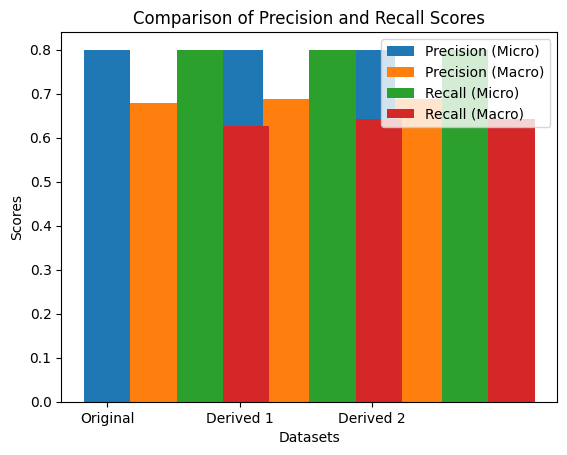

In [ ]:
# Data for visualization
precision_micro_values = [precision_micro_original, precision_micro_derived1, precision_micro_derived2]
recall_micro_values = [recall_micro_original, recall_micro_derived1, recall_micro_derived2]

precision_macro_values = [precision_macro_original, precision_macro_derived1, precision_macro_derived2]
recall_macro_values = [recall_macro_original, recall_macro_derived1, recall_macro_derived2]

# Dataset labels
datasets = ['Original', 'Derived 1', 'Derived 2']

# Bar width
bar_width = 0.35

# Create subplots
fig, ax = plt.subplots()

# Plot precision values
bar1 = ax.bar(datasets, precision_micro_values, bar_width, label='Precision (Micro)')
bar2 = ax.bar([x + bar_width for x in range(len(datasets))], precision_macro_values, bar_width, label='Precision (Macro)')

# Plot recall values
bar3 = ax.bar([x + 2 * bar_width for x in range(len(datasets))], recall_micro_values, bar_width, label='Recall (Micro)')
bar4 = ax.bar([x + 3 * bar_width for x in range(len(datasets))], recall_macro_values, bar_width, label='Recall (Macro)')

# Add labels, title, and legend
ax.set_xlabel('Datasets')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision and Recall Scores')
ax.legend()

# Show the plot
plt.show()


# **Logisitc Regression Analysis**

### **Consistent Micro-Level Performance:**

The Logistic Regression model exhibits consistent performance across all datasets in terms of micro precision and recall, both scoring at 0.8. This consistency at the micro level suggests that the model is equally adept at predicting individual classes, indicating a stable and reliable performance for binary or multi-class classification tasks.

### **Macro Precision and Recall:**

There's a notable difference between the micro and macro scores. While micro precision and recall are consistently high, the macro precision and recall are lower. This discrepancy could indicate that the model performs differently across various classes. It might be very accurate for some classes (contributing to high micro scores) but less so for others (hence the lower macro scores). This is particularly evident in the original dataset where the macro precision and recall are significantly lower than in the derived datasets.

### **Performance on Derived Datasets:**

The model shows slightly improved macro precision and recall on the derived datasets compared to the original dataset. This improvement could be due to the nature of the derived datasets – possibly they are more balanced or have features that are more discriminative for logistic regression.

### **Implications of Class Imbalance:**

The difference in macro and micro scores suggests potential class imbalance issues. In such cases, while the overall accuracy (micro scores) might be high, the model's ability to predict less frequent classes accurately (as reflected in macro scores) is not as strong.

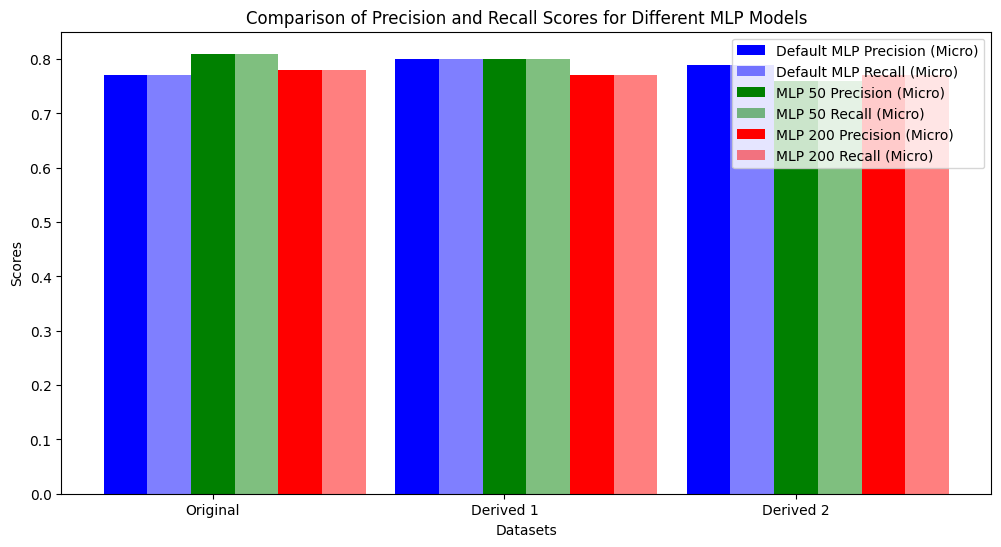

In [ ]:
import numpy as np

# Precision and Recall values for each model on each dataset
precision_micro_values_default = [precision_micro_original_default, precision_micro_derived1_default, precision_micro_derived2_default]
recall_micro_values_default = [recall_micro_original_default, recall_micro_derived1_default, recall_micro_derived2_default]

precision_micro_values_50 = [precision_micro_original_50, precision_micro_derived1_50, precision_micro_derived2_50]
recall_micro_values_50 = [recall_micro_original_50, recall_micro_derived1_50, recall_micro_derived2_50]

precision_micro_values_200 = [precision_micro_original_200, precision_micro_derived1_200, precision_micro_derived2_200]
recall_micro_values_200 = [recall_micro_original_200, recall_micro_derived1_200, recall_micro_derived2_200]

# Dataset labels
datasets = ['Original', 'Derived 1', 'Derived 2']
n_datasets = len(datasets)

# Bar width and positions
bar_width = 0.15
index = np.arange(n_datasets)

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Function to add bars for a specific model
def add_bars(positions, precision_values, recall_values, label_prefix, color):
    ax.bar(positions, precision_values, bar_width, label=label_prefix + ' Precision (Micro)', color=color)
    ax.bar(positions + bar_width, recall_values, bar_width, label=label_prefix + ' Recall (Micro)', color=color, alpha=0.5)

# Adding bars for each model
add_bars(index, precision_micro_values_default, recall_micro_values_default, 'Default MLP', 'blue')
add_bars(index + bar_width * 2, precision_micro_values_50, recall_micro_values_50, 'MLP 50', 'green')
add_bars(index + bar_width * 4, precision_micro_values_200, recall_micro_values_200, 'MLP 200', 'red')

# Add labels, title, and legend
ax.set_xlabel('Datasets')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision and Recall Scores for Different MLP Models')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(datasets)
ax.legend()

# Show the plot
plt.show()

# **MLP Analysis**

### **Performance on Original Dataset:**

The MLP model with 50 hidden layers performs the best on the original dataset, with precision and recall (both micro and macro) higher than the default and 200 hidden layer models. This suggests that a moderate level of model complexity (50 hidden layers) is well-suited for this dataset, striking a balance between underfitting and overfitting.

### **Performance on Derived Dataset 1:**

The MLP model with the default configuration (100 hidden layers) and 50 hidden layers perform equally well in terms of micro precision and recall. However, the default model has slightly better macro precision and recall. This could indicate that the default model generalizes slightly better across different classes in this dataset.

### **Performance on Derived Dataset 2:**

The performance of all models drops in terms of macro precision, with the default model showing the most significant decrease. This could be due to the model's inability to generalize well across all classes in this dataset, possibly indicating class imbalances or more complex data patterns that the model struggles to capture.

### **Effect of Model Complexity:**

Interestingly, increasing the complexity to 200 hidden layers does not improve performance; in fact, it results in the lowest macro precision and recall scores across all datasets. This could be a sign of overfitting, where the model becomes too tailored to the training data and loses its ability to generalize.

# **Comparison**

Comparing the results of the Multilayer Perceptron (MLP) models with those of Logistic Regression, we observe distinct patterns in performance. The MLP models, especially with 50 hidden layers, show a strong performance on the original dataset, suggesting better handling of complex data structures, albeit with a risk of overfitting as seen in the 200-neuron variant. In contrast, Logistic Regression, while simpler and more interpretable, demonstrates remarkable consistency across all datasets, particularly at the micro-level (precision and recall of 0.8), but it falls short in macro precision and recall, potentially due to class imbalances. This comparison highlights the trade-offs between model complexity and generalizability: while MLP can capture more complex patterns, it requires careful tuning to avoid overfitting, whereas Logistic Regression offers stable performance across varied datasets but might need additional strategies to address class-specific accuracy.

## **References**

- https://huggingface.co/docs/transformers/tasks/sequence_classification
- https://iq.opengenus.org/text-preprocessing-in-spacy/
- https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/
- https://www.enjoyalgorithms.com/blog/text-data-pre-processing-techniques-in-ml/
- https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy
- https://iq.opengenus.org/text-preprocessing-in-spacy/
- https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy
- https://towardsdatascience.com/setting-up-text-preprocessing-pipeline-using-scikit-learn-and-spacy-e09b9b76758f
- https://www.kaggle.com/datasets/malharkhatu/airline-passenger-reviews
- https://www.kaggle.com/code/karanchinchpure/nlp-pipeline-details-explained